# CKW visualization notebook:

## Load the data

The data is accessible on: https://open.data.axpo.com/%24web/index.html#dataset-a

In this case, we refer to one of the files indicated in data set "B", namely aggregated data per zip code.

In [1]:
## Necessaries libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm

In [2]:
## Class needed to load the data

class LoadData():
    def __init__(self, start_month : int = 202101, end_month : int = 202311):
        self.start_month = start_month
        self.end_month = end_month
        self.list_month = []
        self.data = pd.DataFrame()
        self.__createListMonth()
        self.__loadData()

    def __createListMonth(self):
    ## create the list of month to load in the correct format YYYYMM
        for year in range(self.start_month // 100, self.end_month // 100 + 1):
            if year == self.end_month // 100:
                for month in range(1, self.end_month % 100 + 1):
                    # Ensure the month is zero-padded if necessary (e.g., 01 instead of 1)
                    formatted_month = f"{month:02d}"
                
                    # Create the date string in the format YYYYMM
                    date = f"{year}{formatted_month}"
                    self.list_month.append(int(date))
            else:
                for month in range(1, 13):
                    # Ensure the month is zero-padded if necessary (e.g., 01 instead of 1)
                    formatted_month = f"{month:02d}"
                
                    # Create the date string in the format YYYYMM
                    date = f"{year}{formatted_month}"
                    self.list_month.append(int(date))
    
    def __loadData(self):
        for month in tqdm(self.list_month, desc="Loading data"):
            url = "https://open.data.axpo.com/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
            self.data = self.data.append(pd.read_csv(url), ignore_index=True)
        print("###################################################### \n")
        print("Every data could be imported from {} {} to {} {}".format('01', self.start_month // 100, self.end_month % 100 , self.end_month // 100))

    def getData(self):
        return self.data
    
    def getListMonth(self):
        return self.list_month
    
    def getStartMonth(self):
        return self.start_month
    
    def getEndMonth(self):
        return self.end_month
    
    def getMonth(self, month : int):
        return self.data[self.data["month"] == month]
    
    def getYear(self, year : int):
        return self.data[self.data["year"] == year]
    


In [3]:
## functions needed to prcess the data by adding useful features

def get_season(month):
    if 3 <= month <= 5:
        return "Spring"
    elif 6 <= month <= 8:
        return "Summer"
    elif 9 <= month <= 11:
        return "Autumn"
    else:
        return "Winter"
    
def replace_high_values_with_previous(df, threshold):
    for index, row in df.iterrows():
        if row['value_watt'] > threshold:
            previous_index = df.index.get_loc(index) - 1
            if previous_index >= 0:
                previous_value_watt = df.at[df.index[previous_index], 'value_watt']
                previous_value_kwh = df.at[df.index[previous_index], 'value_kwh']
                df.at[index, 'value_watt'] = previous_value_watt
                df.at[index, 'value_kwh'] = previous_value_kwh


def process_data(data : pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    ## Create new features and group by timestamp (we do not care about the area_code)
    cons_Zurich = data.groupby("timestamp").sum().drop(columns=["area_code"])
    cons_ind_Zurich = cons_Zurich.copy()  # Make a copy to avoid modifying the original DataFrame
    cons_ind_Zurich["value_kwh"] = cons_Zurich["value_kwh"] / cons_Zurich["num_meter"]
    # cons_ind_Zurich = cons_ind_Zurich.drop(columns=["num_meter"])
    cons_ind_Zurich["value_watt"] = cons_ind_Zurich["value_kwh"] * 1000 * 4
    cons_ind_Zurich.index = pd.to_datetime(cons_ind_Zurich.index)
    cons_ind_Zurich["year"] = cons_ind_Zurich.index.year
    cons_ind_Zurich["month"] = cons_ind_Zurich.index.month
    cons_ind_Zurich["week"] = cons_ind_Zurich.index.week
    cons_ind_Zurich['season'] = cons_ind_Zurich['month'].apply(get_season)
    cons_ind_Zurich["day_of_week"] = cons_ind_Zurich.index.day_name()
    cons_ind_Zurich["day"] = cons_ind_Zurich.index.day
    cons_ind_Zurich["time"] = cons_ind_Zurich.index.strftime('%H:%M')
    ## use in order to replace some outliers (errors) with very high values
    replace_high_values_with_previous(cons_ind_Zurich, 5000)

    return cons_ind_Zurich

## First goal: visualize the consumption of all smart meter over time

-> aggregation over all districts \
-> then divide by number of smart meters to get an average household consumption \
-> adding additionnal features like season

In [4]:
data = LoadData(202101, 202310).getData()
cons_ind_Zurich = process_data(data)
cons_ind_Zurich.head()

Loading data:   0%|          | 0/34 [00:00<?, ?it/s]

/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_887/1558802128.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data = self.data.append(pd.read_csv(url), ignore_index=True)
Loading data:   3%|▎         | 1/34 [00:01<01:02,  1.91s/it]/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_887/1558802128.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data = self.data.append(pd.read_csv(url), ignore_index=True)
Loading data:   6%|▌         | 2/34 [00:03<00:47,  1.47s/it]/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_887/1558802128.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data = self.data.append(pd.read_csv(url), ignore_index=True)
Loading data:   9%|▉         | 3/3

###################################################### 

Every data could be imported from 01 2021 to 10 2023


/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_887/732003627.py:34: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  cons_ind_Zurich["week"] = cons_ind_Zurich.index.week


,num_meter,value_kwh,value_watt,year,month,week,season,day_of_week,day,time
timestamp,,,,,,,,,,
2020-12-31 23:00:00+00:00,38951,0.347131,1388.524084,2020,12,53,Winter,Thursday,31,23:00
2020-12-31 23:15:00+00:00,38948,0.334754,1339.014214,2020,12,53,Winter,Thursday,31,23:15
2020-12-31 23:30:00+00:00,38949,0.290727,1162.909178,2020,12,53,Winter,Thursday,31,23:30
2020-12-31 23:45:00+00:00,39215,0.320606,1282.425074,2020,12,53,Winter,Thursday,31,23:45
2021-01-01 00:00:00+00:00,39216,0.315701,1262.805470,2021,1,53,Winter,Friday,1,00:00


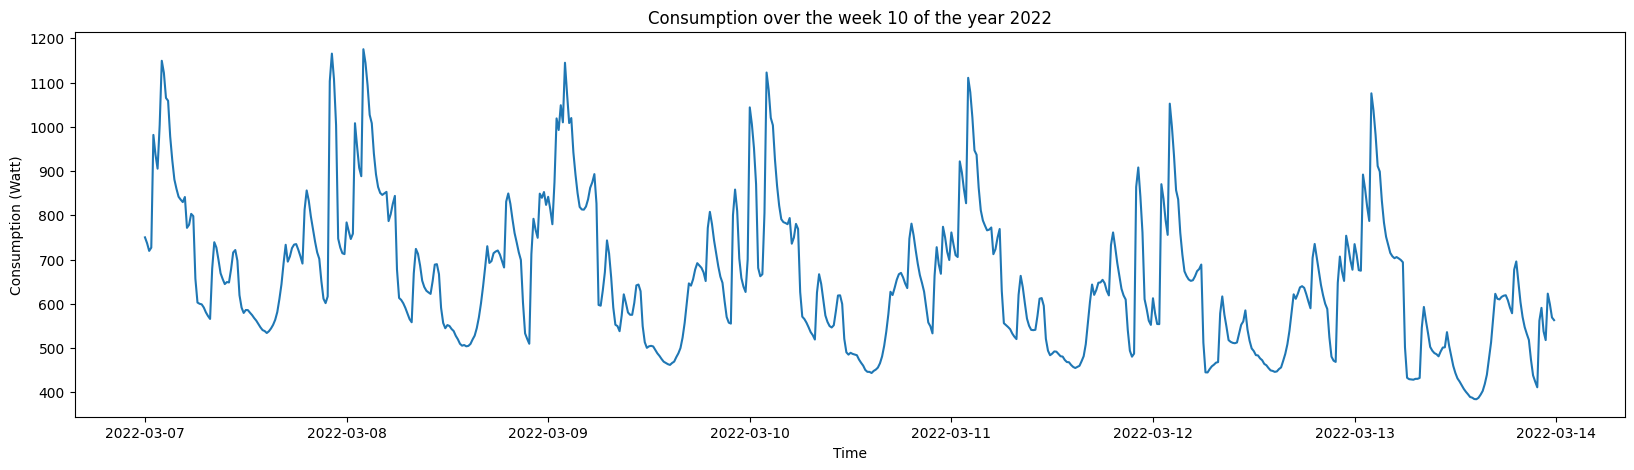

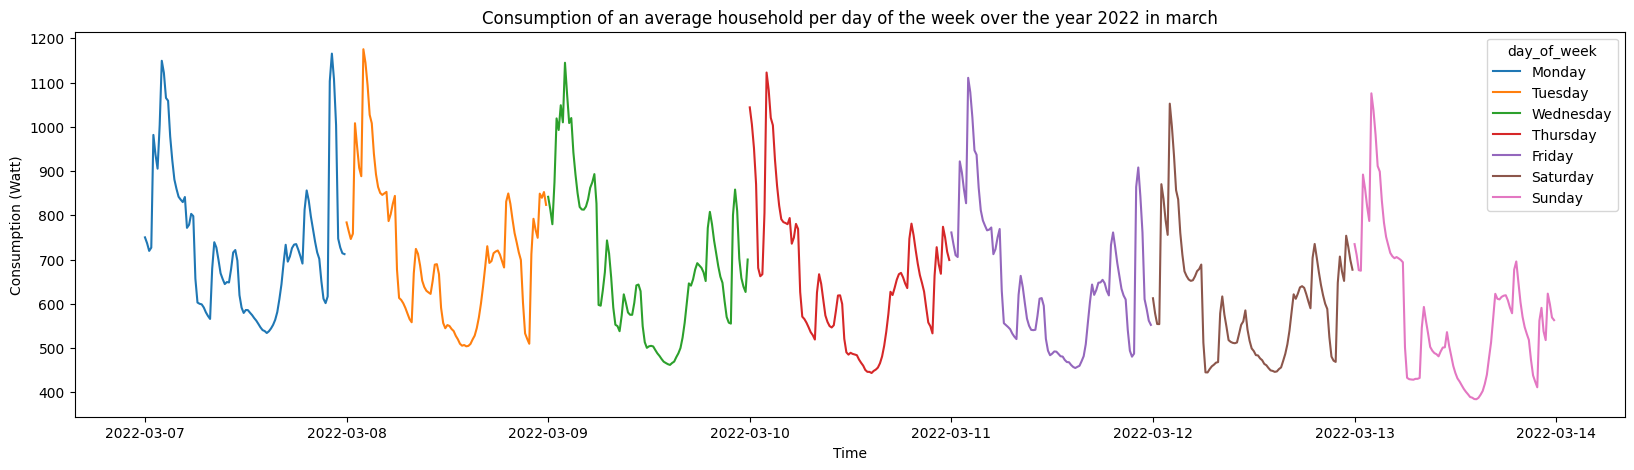

In [5]:
## Enables to visualize the data by selecting a specific week and year

year_to_select = 2022
week_to_select = 10

subset = cons_ind_Zurich[(cons_ind_Zurich["year"] == year_to_select) & (cons_ind_Zurich["week"] == week_to_select)]

plt.figure(figsize=(20,5))
plt.plot(subset.index, subset.value_watt)
plt.xlabel("Time")
plt.ylabel("Consumption (Watt)")
plt.title("Consumption over the week {} of the year {}".format(week_to_select, year_to_select))
plt.show()

plt.figure(figsize=(20,5))
sns.lineplot(data=subset, x="timestamp", y="value_watt", hue="day_of_week")

plt.xlabel("Time")
plt.ylabel("Consumption (Watt)")
plt.title("Consumption of an average household per day of the week over the year 2022 in march") 


plt.show()

/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_887/2377466896.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  av_day =  cons_ind_Zurich.groupby(["season","time"]).mean().drop(columns=["year", "month", "day", "num_meter", "value_kwh"])
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_887/2377466896.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test = cons_ind_Zurich.groupby(["week","time","season"]).mean()


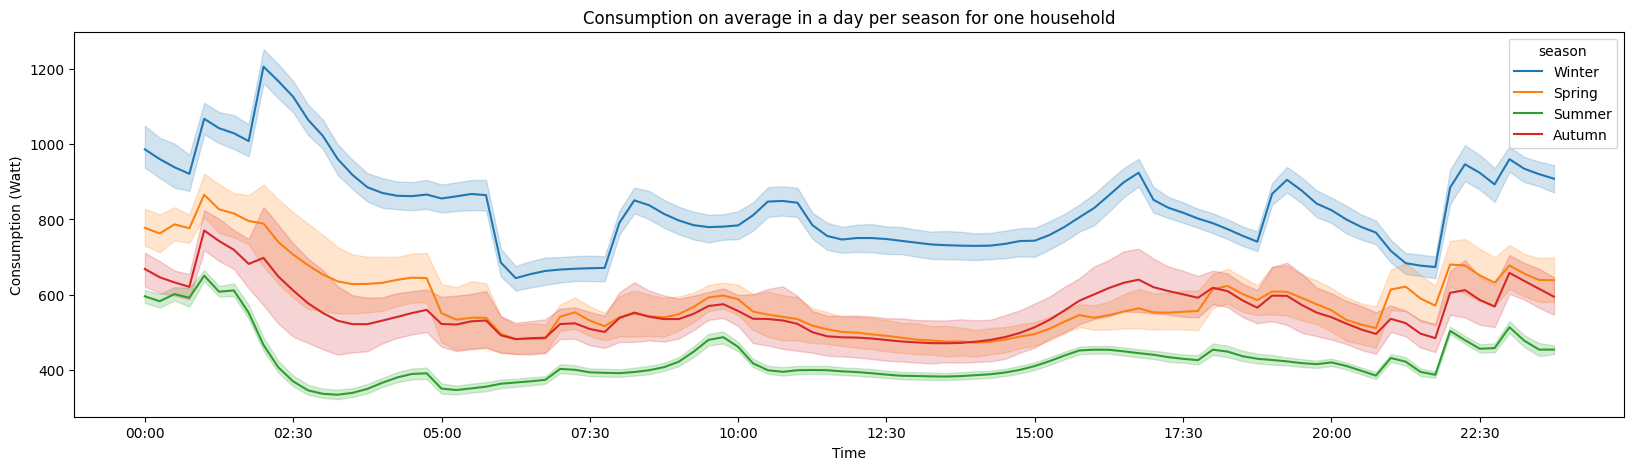

In [12]:
## plot the consumption in a day on average per season according to time
av_day =  cons_ind_Zurich.groupby(["season","time"]).mean().drop(columns=["year", "month", "day", "num_meter", "value_kwh"])
test = cons_ind_Zurich.groupby(["week","time","season"]).mean()

plt.figure(figsize=(20,5))
sns.lineplot(data=test, x="time", y="value_watt", hue="season")
plt.xticks(np.arange(0, len(av_day.index.get_level_values('time'))/(4) , 10))
plt.xlabel("Time")
plt.ylabel("Consumption (Watt)")
plt.title("Consumption on average in a day per season for one household")


plt.show()